### NN1
Tymoteusz Urban

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\tymek\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\tymek\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
class NeuralNetwork:
    
    def __init__(self, layers, weights=None, biases=None, activations=None):
        self.layers = layers
        self.num_layers = len(layers)
        
        if weights is None:
            self.weights = [np.random.randn(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [np.random.randn(layers[i]) for i in range(1, self.num_layers)]
        else:
            self.biases = biases
        
        if activations is None:
            self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['linear']
        else:
            self.activations = activations
        
        activation_functions = {
            'sigmoid': self._sigmoid,
            'linear': self._linear
        }
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), self.activations))

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _linear(self, z):
        return z
    
    def feedforward(self, a):
        for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
            z = np.dot(a, w) + b
            a = func(z)
        return a
    
    def predict(self, df):
        if isinstance(df, pd.Series):
            return df.apply(lambda x: self.feedforward(np.array([x]))[0])
        else:
            return self.feedforward(np.array([df]), print_values=True)

Wytestowanie czy różne architektury działają i nie wyrzucają błędów:

1*5

In [5]:
weights_1 = [np.random.randn(1, 5), np.random.randn(5, 1)]
biases_1 = [np.random.randn(5), np.random.randn(1)] 
activations_1 = ['sigmoid', 'linear']

In [6]:
nn_1 = NeuralNetwork([1, 5, 1], weights=weights_1, biases=biases_1, activations=activations_1)

In [7]:
nn_1.feedforward(np.array([1]))

array([0.72945523])

1*10

In [8]:
weights_2 = [np.random.randn(1, 10), np.random.randn(10, 1)]
biases_2 = [np.random.randn(10), np.random.randn(1)] 
activations_2 = ['sigmoid', 'linear']

In [9]:
nn_2 = NeuralNetwork([1, 10, 1], weights=weights_2, biases=biases_2, activations=activations_2)

In [10]:
nn_2.feedforward(np.array([1]))

array([0.61094034])

2*5

In [11]:
weights_3 = [np.random.randn(1, 5), np.random.randn(5, 5), np.random.randn(5, 1)]
biases_3 = [np.random.randn(5), np.random.randn(5), np.random.randn(1)] 
activations_3 = ['sigmoid', 'sigmoid', 'linear']

In [12]:
nn_3 = NeuralNetwork([1, 5, 5, 1], weights=weights_3, biases=biases_3, activations=activations_3)

In [13]:
nn_3.feedforward([1])

array([1.58304051])

### Dane

In [14]:
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [15]:
square_simple = pd.read_csv("dane/regression/square-simple-test.csv", index_col=0)
steps_large = pd.read_csv("dane/regression/steps-large-test.csv", index_col=0)

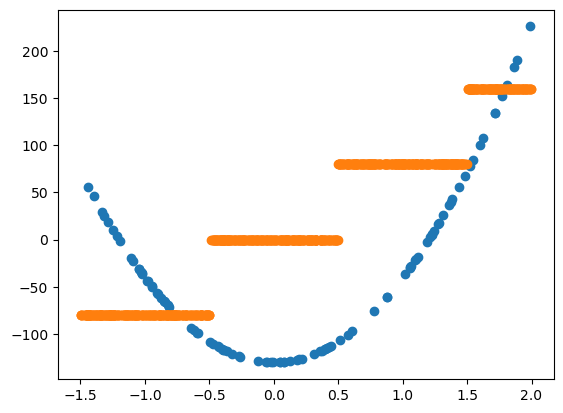

In [16]:
plt.scatter(square_simple['x'], square_simple['y'])
plt.scatter(steps_large['x'], steps_large['y'])
plt.show()

In [17]:
for network in [nn_1, nn_2, nn_3]:
    for dataset in [square_simple, steps_large]:
        y_pred = network.predict(dataset['x'])
        print(MSE(dataset['y'], y_pred))

8734.761580170587
7403.605926132437
8946.247610100523
7586.170716282624
8821.53446911994
7385.566789336105


Wszystko działa jak powinno, możemy przejść do dobierania wag

## Ustawianie wag

#### square_simple dataset

1 warstwa 5 neuronów

Intuicyjnie, dla x < 0 chcielibyśmy otrzymać coś podobnego do sigm(-x), a dla x > 0 do sigm(x). Potrzebujemy tylko fragmentów w którym funkcja sigmoidalna zaczyna wzrastać. Po serii eksperymentów udało się ustalić wektory wag i biasów (zależne od współczynników a,b,c,d), przy użyciu których da się stworzyć funkcję zbliżoną do square_simple:

In [18]:
# weights = [np.array([[a, -a,0,0,0]]), np.array([[b],[b],[0],[0],[0]])]
# biases = [np.array([-c,-c,0,0,0]), np.array([-d])]

gdzie: a - nachylenie, b - skalowanie, c - punkt rozpoczęcia nachylania, d - przesunięcie

Następnie, przy odpowiednim ustawieniu wartości tych 4 współczynników, udało mi się uzyskać MSE mniejsze od 9

In [36]:
a = 2  # nachylenie
b = 600 # skalowanie
c = 3.4  # punkt rozpoczęcia nachylania
d = 165  # przesunięcie

MSE: 8.586385303164745


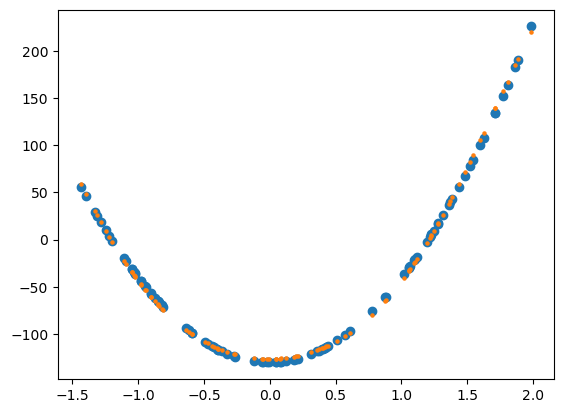

In [37]:
weights = [np.array([[a, -a,0,0,0]]), np.array([[b],[b],[0],[0],[0]])]
biases = [np.array([-c,-c,0,0,0]), np.array([-d])]
nn = NeuralNetwork([1, 5, 1], weights=weights, biases=biases)
y_pred1 = nn.predict(square_simple['x'])
print(f"MSE: {MSE(square_simple['y'], y_pred1)}")
plt.scatter(square_simple['x'], square_simple['y'])
plt.scatter(square_simple['x'], y_pred1, s=5)
plt.show()

1 warstwa 10 neuronów

Można zauważyć, że gdy udało nam się dostać MSE < 9 dla warstwy z 5 neuronami, to możemy tych wag użyć dla architektury z 10 neuronami, a pozostałe ustawić na 0. Wtedy te dodatkowe neurony nie będą jakkolwiek wpływać na wyniki, i otrzymamy bliźniaczą sieć do tej z 5 neuronami

In [34]:
weights = [np.array([[a, -a,0,0,0,0,0,0,0,0]]), np.array([[b],[b],[0],[0],[0],[0],[0],[0],[0],[0]])]
biases = [np.array([-c,-c,0,0,0,0,0,0,0,0]), np.array([-d])]

MSE: 8.586385303164745


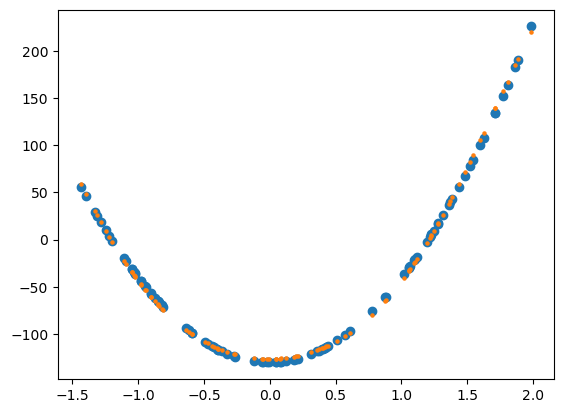

In [35]:
nn = NeuralNetwork([1, 10, 1], weights=weights, biases=biases)
y_pred2 = nn.predict(square_simple['x'])
print("MSE:", MSE(square_simple['y'], y_pred2))
plt.scatter(square_simple['x'], square_simple['y'])
plt.scatter(square_simple['x'], y_pred2, s=5)
plt.show()

2 warstwy po 5 neuronów

Tutaj działamy na podobnej zasadzie, ale jako że już otrzymaliśmy MSE < 9 dla poprzednich architektur, to nie będę się tutaj aż tak długo męczył żeby uzyskać MSE < 9, tylko spróbuję wmiarę dobrze dopasować funkcję na wykresie

In [23]:
e = 6
f = 1160

In [24]:
weights = [np.array([[a/2 + 0.3, -a, 0, 0, 0]]),
 np.array([[e-1, 0, 0, 0, 0],
           [0, e, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]
]),
 np.array([[b*2 + 100],
        [b],
        [0],
        [0],
        [0]])]
biases = [np.array([-c, -c, 0,0,0]),
 np.array([0,0,0,0,0]),
 np.array(-f)]

MSE: 27.294588419952515


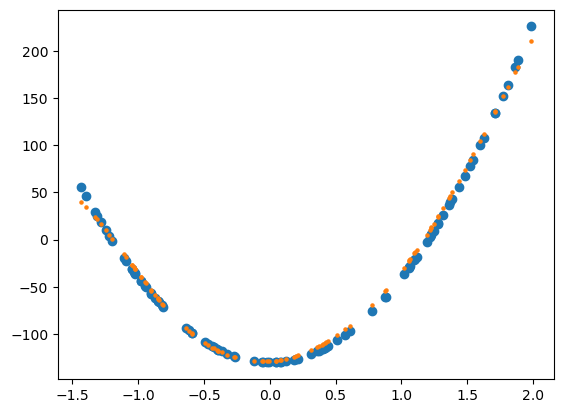

In [25]:
nn = NeuralNetwork([1, 5, 5, 1], weights=weights, biases=biases)
y_pred3 = nn.predict(square_simple['x'])
print("MSE:", MSE(square_simple['y'], y_pred3))
plt.scatter(square_simple['x'], square_simple['y'])
plt.scatter(square_simple['x'], y_pred3, s=5)
plt.show()

#### steps_large dataset

1 warstwa 5 neuronów

Korzystając ze wskazówki z zajęć ustawiłem pierwsze 3 wagi na 100, a biasy na 50, -50 i -150 w celu stworzenia "przesunięć" funkcji sigmoidalnej. W drugim wektorze wag pierwsze 3 wagi ustawiłem na 80 żeby uzyskać odpowiedni przedział wartości, a ostatnim biasem przesunałęm wszystko w dół o 80.

In [32]:
weights = [np.array([[100,100,100,0,0]]), 
           np.array([[80],
                    [80],
                    [80],
                    [0],
                    [0]])]
biases = [np.array([50,-50,-150,0,0]), np.array([-80])]

MSE: 18.700800789479377


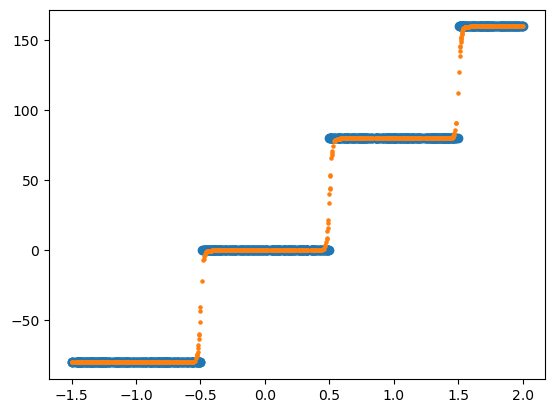

In [33]:
nn = NeuralNetwork([1, 5, 1], weights=weights, biases=biases)
y_pred4 = nn.predict(steps_large['x'])
print(f"MSE: {MSE(steps_large['y'], y_pred4)}")
plt.scatter(steps_large['x'], steps_large['y'])
plt.scatter(steps_large['x'], y_pred4, s=5)
plt.show()

Następnie znacząco zwiększyłem wartości w pierwszym wektorze wag i biasów, żeby moje złożenie funkcji sigmoidalnych było bardziej kanciaste, a co za tym idzie lepiej dopasowane do zbioru steps large.

In [28]:
# nowe wagi
weights = [np.array([[12800,12800,1600,0,0]]), 
           np.array([[80],
                    [80],
                    [80],
                    [0],
                    [0]])]
biases = [np.array([6400,-6400,-2400,0,0]), np.array([-80])]

MSE: 0.01913272440047482


C:\Users\tymek\AppData\Local\Temp\ipykernel_11744\3663408964.py:29: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


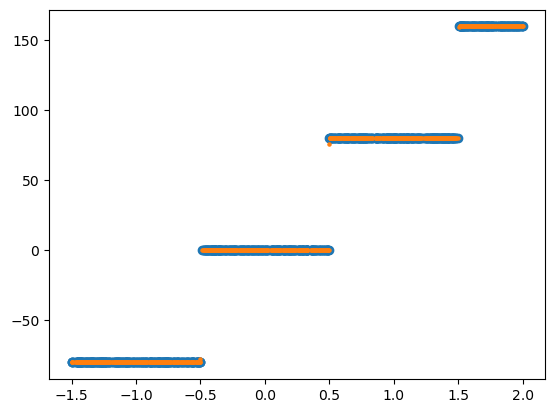

In [30]:
nn = NeuralNetwork([1, 5, 1], weights=weights, biases=biases)
y_pred4 = nn.predict(steps_large['x'])
print(f"MSE: {MSE(steps_large['y'], y_pred4)}")
plt.scatter(steps_large['x'], steps_large['y'])
plt.scatter(steps_large['x'], y_pred4, s=5)
plt.show()

1 warstwa 10 neuronów

Tak samo jak wcześniej uzupełniamy wektory zerami.

In [38]:
weights = [np.array([[12800,12800,1600,0,0,0,0,0,0,0]]), 
           np.array([[80],
                    [80],
                    [80],
                    [0],
                    [0],
                    [0],
                    [0],
                    [0],
                    [0],
                    [0],])]
biases = [np.array([6400,-6400,-2400,0,0,0,0,0,0,0]), np.array([-80])]

MSE: 0.01913272440047482


C:\Users\tymek\AppData\Local\Temp\ipykernel_11744\3663408964.py:29: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


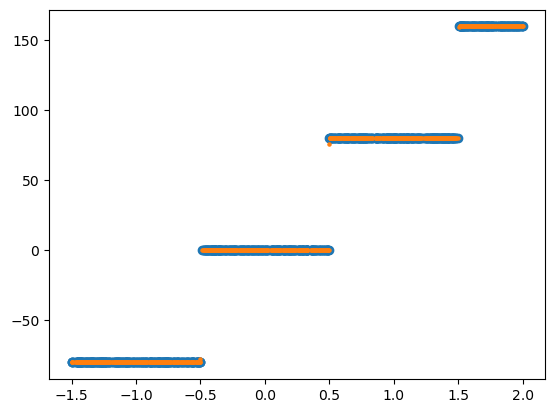

In [39]:
nn = NeuralNetwork([1, 10, 1], weights=weights, biases=biases)
y_pred5 = nn.predict(steps_large['x'])
print(f"MSE: {MSE(steps_large['y'], y_pred5)}")
plt.scatter(steps_large['x'], steps_large['y'])
plt.scatter(steps_large['x'], y_pred5, s=5)
plt.show()

2 warstwy po 5 neuronów

Przy użyciu poprzednich wag, stworzeniu "niepełnej" macierzy jednostkowej i lekkiej modyfikacji 3 wektora wag i 3 wektora biasów w tej architekturze także udało się uzyskać bardzo małe MSE

In [40]:
weights = [np.array([[12800,12800,1600,0,0]]),
 np.array([[1, 0, 0, 0, 0],
           [0, 1, 0, 0, 0],
           [0, 0, 1, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]]),
 np.array([[345],
           [345],
           [345],
        [0],
        [0]])]
biases = [np.array([6400,-6400,-2400,0,0]),
 np.array([0,0,0,0,0]),
 np.array([-597])]

MSE: 0.12377715156568428


C:\Users\tymek\AppData\Local\Temp\ipykernel_11744\3663408964.py:29: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


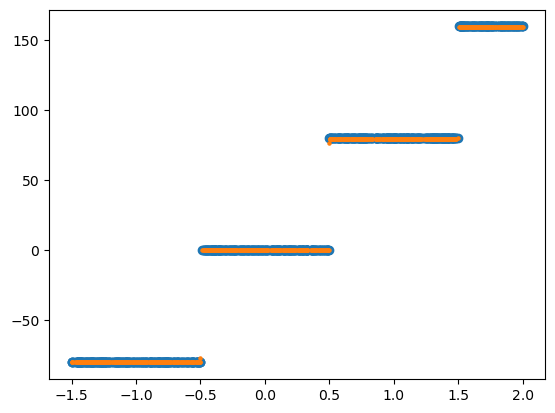

In [41]:
nn = NeuralNetwork([1, 5, 5, 1], weights=weights, biases=biases)
y_pred6 = nn.predict(steps_large['x'])
print("MSE:", MSE(steps_large['y'], y_pred6))
plt.scatter(steps_large['x'], steps_large['y'])
plt.scatter(steps_large['x'], y_pred6, s=5)